<a href="https://colab.research.google.com/github/alxkzncoff/house_price_prediction/blob/master/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INSTALL

Этот шаг нужно делать, если запуск происходит через Google Colab.

In [1]:
!pip install catboost
!pip install PyDrive
!mkdir work_dir

     |████████████████████████████████| 65.8MB 63kB/s 


# DEFINE

In [2]:
DATA_PATH                   = '/content/work_dir'  # для Google drive
# DATA_PATH                   = 'data'
RANDOM_SEED                 = 42

# IMPORT

In [3]:
# General
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 50)

# ML
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder

from catboost import CatBoostRegressor
from catboost import Pool
from catboost import cv
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# ADD GOOGLE DRIVE

Этот шаг нужно делать, если запуск происходит через Google Colab.

In [4]:
# Data access
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [5]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [6]:
# Download flats.csv from google drive to Colab VM.
downloaded = drive.CreateFile({'id':"1klMxLa0QAOdjiH_znstP4bCSUy57rUtd"}) # откуда берем файл
downloaded.GetContentFile(DATA_PATH+'/df.csv') # куда сохраняем файл в вирутальной машине колаба

# VIEW DATA

In [7]:
df = pd.read_csv(DATA_PATH+'/df.csv',
                 dtype={'rooms': str, 'floors': str, 'total_floors': str})

In [8]:
print('Data:')
display(df)
print('\n')

print('NaNs:')
display(df.isnull().sum())
print('\n')

print("Numbers of column's unique values:")
display(df.select_dtypes('object').nunique())
print('\n')

print('Shape:')
display(df.shape)

Data:


,flat_type,object_type,rooms,floors,square,price,build_matireal,district_rating,underground,total_floors,metro_station,district
0,Квартира,Новостройка,2,11,4.070735,16.359441,Монолит,"4,0",1000.0,12,Звездная,Московский
1,Квартира,Новостройка,1,18,3.908015,15.967274,Монолит,"3,9",3600.0,20,Комендантский проспект,Приморский
2,Квартира,Вторичная,3,1,4.146304,15.363073,Панель,"3,6",1000.0,5,Обухово,Невский
3,Квартира,Вторичная,1,10,3.941582,16.341239,Монолит,"3,8",2800.0,14,Площадь Ленина,Калининский
4,Квартира,Вторичная,1,6,3.931826,16.461685,Монолит,"3,7",797.0,10,Площадь А. Невского,Центральный
...,...,...,...,...,...,...,...,...,...,...,...,...
40325,Квартира,Вторичная,3,1,4.406719,16.092778,Кирпич,"3,9",256.0,5,Удельная,Выборгский
40326,Квартира,Вторичная,3,14,4.483003,16.418571,Монолит,"3,7",3600.0,17,Площадь Ленина,Калининский
40327,Квартира,Вторичная,1,5,3.797734,16.212496,Монолит,"3,7",877.0,12,Лиговский проспект,Центральный
40328,Квартира,Вторичная,2,18,4.204693,15.830414,Монолит,"3,8",4800.0,19,Сосновая Поляна,Красносельский




NaNs:


flat_type          0
object_type        0
rooms              0
floors             0
square             0
price              0
build_matireal     0
district_rating    0
underground        0
total_floors       0
metro_station      0
district           0
dtype: int64



Numbers of column's unique values:


flat_type           2
object_type         2
rooms               5
floors             25
build_matireal      3
district_rating    10
total_floors       26
metro_station      77
district           14
dtype: int64



Shape:


(40330, 12)

# MODEL 1: Наивная модель

Для начала попробую построить "наивную" модель, чтобы было от чего отталкиваться и понимать, становиться лучше или хуже после внесения изменений.

In [10]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [11]:
# split данных
df_train, df_test = train_test_split(df, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

predicts = []
for index, row in pd.DataFrame(df_test[['rooms', 'square']]).iterrows():
    query = f"rooms == '{row[0]}' and square == '{row[1]}'"
    predicts.append(df_train.query(query)['price'].median())

predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# держу в голове, что в EDA я логорифмировал таргет, нужно произвести обратное действие
print(f"Наивная модель MAPE: {(mape(np.expm1(df_test['price']), np.expm1(predicts.values[:, 0])))*100:0.2f}%") 

Наивная модель MAPE: 20.72%


# MODEL 2: `scikit-learn LinearRegression`

In [20]:
def simple_model(data, numerical_features, categorical_features, 
                 TRAIN_RATIO=0.75, VALIDATION_RATIO=0.15, TEST_RATIO=0.10):
    
    """
    Description:
        
        Функция преобразует категориальные признаки в dummy перменные, обучает модель
        и делает предсказание. За основу взята LinearRegression из sklearn.
    
    Parametrs:
    
        categorical_features  - спико категориальных признаков из                   | [list]
                                исследуемой таблицы                          
        numerical_features    - спико числовых признаков из                         | [list]
                                исследуемой таблицы   
        TRAIN_RATIO           - объем тренировочных данных                          | float       | default - 0.75
        VALIDATION_RATIO      - объем валидационных данных                          | float       | default - 0.15
        TEST_RATIO            - объем тестовых данных                               | float       | default - 0.10
        RANDOM_SEED           - константа для воспроизводимости эксперементов       | int         | default - 42

    Returns:
    
        result                - датафрейм с истинными и предсказанными значениям    | DataFrame
        
    """
    
    #Dummies
    dum_df = pd.get_dummies(data, columns=cat)
    
    # Normalization
    try:
        MMS = MinMaxScaler()
    except ImportError:
        print('You have to import MinMaxScaler from sklearn.preprocessing')
            
    MMS.fit(dum_df[numerical_features])
    dum_df[numerical_features] = MMS.transform(dum_df[numerical_features])
    print('Data: \n')
    display(dum_df)

    # Train, validation, test split
    X = dum_df.drop(columns=['price'])
    y = dum_df['price']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 1 - TRAIN_RATIO, 
                                                                    shuffle = True, random_state = RANDOM_SEED)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, 
                                                                test_size = TEST_RATIO/(TEST_RATIO + VALIDATION_RATIO), 
                                                                shuffle = True, random_state = RANDOM_SEED)    
    
    #Fit model
    simple_reg = LinearRegression().fit(X_train, y_train)
    
    #Val predict
    val_pred = simple_reg.predict(X_val)
    print(f"Validation mape: {(np.mean(np.abs((np.expm1(val_pred)-np.expm1(y_val))/np.expm1(y_val))))*100:0.2f}%\n")
    
    #Test predict
    test_pred = simple_reg.predict(X_test)
    print(f"Test mape: {(np.mean(np.abs((np.expm1(test_pred)-np.expm1(y_test))/np.expm1(y_test))))*100:0.2f}%\n")
    
    # DataFrame with results
    result_dict = {'target': np.expm1(y_test), 'predict': np.expm1(test_pred)}
    result = pd.DataFrame(data = result_dict)
    
    return result

In [22]:
cat = ['flat_type', 'rooms', 'object_type', 'floors', 'build_matireal', 
       'district_rating', 'total_floors',  'metro_station',  'district']
num = ['square', 'underground']

prediction = simple_model(df, num, cat)

Data: 



,square,price,underground,flat_type_Квартира,flat_type_Студия,rooms_1,rooms_2,rooms_3,rooms_4,rooms_5,object_type_Вторичная,object_type_Новостройка,floors_1,floors_10,floors_11,floors_12,floors_13,floors_14,floors_15,floors_16,floors_17,floors_18,floors_19,floors_2,floors_20,...,metro_station_Технологический ин-т I,metro_station_Технологический ин-т II,metro_station_Удельная,metro_station_Улица Дыбенко,metro_station_Фрунзенская,metro_station_Черная речка,metro_station_Чернышевская,metro_station_Чкаловская,metro_station_Шоссейная,metro_station_Шувалово,metro_station_Электросила,district_Адмиралтейский,district_Ваcилеостровский,district_Всеволожский,district_Выборгский,district_Калининский,district_Кировский,district_Красногвардейский,district_Красносельский,district_Московский,district_Невский,district_Петроградский,district_Приморский,district_Фрунзенский,district_Центральный
0,0.496283,16.359441,0.2000,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,0.448009,15.967274,0.7200,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0.518702,15.363073,0.2000,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0.457967,16.341239,0.5600,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,0.455073,16.461685,0.1594,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40325,0.595960,16.092778,0.0512,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
40326,0.618591,16.418571,0.7200,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
40327,0.415291,16.212496,0.1754,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
40328,0.536024,15.830414,0.9600,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


Validation mape: 13.54%

Test mape: 13.92%



In [23]:
prediction

,target,predict
22067,11000000.0,1.040795e+07
16510,11300000.0,1.167416e+07
12423,7030560.0,7.925207e+06
39858,5320000.0,5.671327e+06
26087,3070000.0,2.653072e+06
...,...,...
29020,6960600.0,6.831747e+06
17844,6710000.0,7.462330e+06
25697,3800000.0,3.806270e+06
4212,8960319.0,8.510813e+06


**13.92%** очень хороший результат. Уменьшил ошибку на **~7%**. В целом это благодоря предворительной обработке данных. Поробую улучшить результат с помощью `CatBoost`.

# MODEL 3: CatBoostRegressor

Один из плюсов `CatBoost` в том, что он способен работать с категориальными данными без предворительной обработке. В документации к библиотека настоятельно рекомендуют не обрабатывать категориальные признаки перед использованием. Так как подовляющее большенство признаков в моем датафрейме - категориальные, то это отличный вариант.

## Class FlatsPredict

In [118]:
class FlatsPredict:
    
    """
    Description:
    
        Подбор наилучших параметров для модели. Разделение данных на тернировочную, 
        валидационную и тестовую. Объем каждой выборки можно назначить самому.
        Обучение модели на тренировочных и валидационных данных. Вывод информации о
        ходе обучения. Проверка обученной модели на тестовых данных. 
        За основу используеться библиотека CatBoost.
        
        Пример:
        
            fp = FlatsPredict(categorical_features, numerical_features)

            # Поиск наилучших параметров:
            params = {'learning_rate': [0.001, 0.01],
                      'metric': ['MAE', 'RMSE']}

            fp.search_best_params(DataFrame, params)

            # Обучение модели:
            ctr = CatBoostRegressor(набор параметров, полученный после пред. шага)

            fp.fit_model(DataFrame, CatBoostRegressor)
              
    Parametrs:
    
        categorical_features  - спико категориальных признаков из                   | [list]
                                исследуемой таблицы                          
        numerical_features    - спико числовых признаков из                         | [list]
                                исследуемой таблицы   
        TRAIN_RATIO           - объем тренировочных данных                          | float       | default - 0.75
        VALIDATION_RATIO      - объем валидационных данных                          | float       | default - 0.15
        TEST_RATIO            - объем тестовых данных                               | float       | default - 0.10
        RANDOM_SEED           - константа для воспроизводимости эксперементов       | int         | default - 42
        VERBOSE               - Как часто выводить информацию об обучении,          | int, bool   | default - 500
                                если передаем int. Выводить всю информацию или
                                не выводить, если передем bool 
        
    Methods:
    
        search_best_params()  - перебор параметров модели, для поиска лучших значений.
        fit_model()           - нормализует данные, обучает модель, рисует график 
                                обучения, возвращает датафрейм с результатом.
        
    Return:
    
        None
    
    """
 

    def __init__(self, categorical_features, numerical_features, TRAIN_RATIO=0.75, 
                 VALIDATION_RATIO=0.15, TEST_RATIO=0.10, RANDOM_SEED=42, VERBOSE=1000):
        
        self.categorical_features = categorical_features
        self.numerical_features = numerical_features
        self.TRAIN_RATIO = TRAIN_RATIO
        self.VALIDATION_RATIO = VALIDATION_RATIO
        self.TEST_RATIO = TEST_RATIO
        self.RANDOM_SEED = RANDOM_SEED
        self.VERBOSE = VERBOSE

        
    def search_best_params(self, data, grid):

        """
        Description:

            Перебора параметров модели, для поиска лучших значений.

        Parametrs:

            data                  - таблица с данными                                   | DataFrame
            grid                  - словарь с параметрами, среди которых ищем лучшие    | {dict}

        Return:
        
            grid_search_result   - набор лучших параметров

        """
        
        # Normalization
        try:
            MMS = MinMaxScaler()
        except ImportError:
            print('You have to import MinMaxScaler from sklearn.preprocessing')
            
        MMS.fit(data[self.numerical_features])
        data[self.numerical_features] = MMS.transform(data[self.numerical_features])
        print('Data: \n')
        display(data.head(5))

        # Train, validation, test split
        X = data.drop(columns=['price'])
        y = data['price']
        
        try:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 1 - self.TRAIN_RATIO, 
                                                                shuffle = True, random_state = self.RANDOM_SEED)
            X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, 
                                                            test_size = self.TEST_RATIO/(self.TEST_RATIO + self.VALIDATION_RATIO), 
                                                            shuffle = True, random_state = self.RANDOM_SEED)
        except ImportError:
            print('You have to import train_test_split from sklearn.model_selection')

        # Data preparetion for CatBoost
        train_data = Pool(data=X_train, label=y_train, cat_features=self.categorical_features)   # Тренировочные данные
        val_data  = Pool(data=X_val, label=y_val, cat_features=self.categorical_features)        # Валидационные данные
        test_data = Pool(data=X_test, cat_features=self.categorical_features)                    # Тестовые данные

        # Grid search
        try:
            model = CatBoostRegressor()
        except ImportError:
            print('You have to import CatBoostRegressor from catboost')
            
        grid_search_result = model.grid_search(grid, 
                                               train_data,  
                                               partition_random_seed=self.RANDOM_SEED,
                                               search_by_train_test_split=True,
                                               calc_cv_statistics=True,
                                               verbose=self.VERBOSE)

        return grid_search_result
    
    
    def fit_model(self, data, ctr, metric='RMSE'):

        """ 
        Description:

            Нормализует данные, обучает модель, строит график обучения, возвращает датафрейм с результатом.

        Parametrs:

            data                  - таблица с данными                                   | DataFrame
            ctr                   - CatBoostRegressor() с параметрами                   | object
            metric                - метрика для графика                                 | str         | default - RMSE
                                   (должна совпадать с метрикой модели)

        Return:

            model                 - обученную модель                                    | object
            result                - датафрейм с истинными и предсказанными значениям    | DataFrame

        """

        # Normalization
        try:
            MMS = MinMaxScaler()
        except ImportError:
            print('You have to import MinMaxScaler from sklearn.preprocessing')
   
        MMS.fit(data[self.numerical_features])
        data[self.numerical_features] = MMS.transform(data[self.numerical_features])
        print('Data: \n')
        display(data[self.numerical_features + self.categorical_features].head(5))

        # Train, validation, test split
        X = data[self.numerical_features + self.categorical_features]
        y = data['price']
        
        try:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 1 - self.TRAIN_RATIO, 
                                                                shuffle = True, random_state = self.RANDOM_SEED)
            X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, 
                                                            test_size = self.TEST_RATIO/(self.TEST_RATIO + self.VALIDATION_RATIO), 
                                                            shuffle = True, random_state = self.RANDOM_SEED)
        except ImportError:
            print('You have to import train_test_split from sklearn.model_selection')

        # Data preparetion for CatBoost
        train_data = Pool(data=X_train, label=y_train, cat_features=self.categorical_features)   # Тренировочные данные
        val_data  = Pool(data=X_val, label=y_val, cat_features=self.categorical_features)        # Валидационные данные
        test_data = Pool(data=X_test, cat_features=self.categorical_features)                    # Тестовые данные

        # Fit model
        print('\n')
        print('Learning...')
        model = ctr.fit(train_data,
                        eval_set=val_data,
                        verbose_eval=self.VERBOSE,
                        use_best_model=True)

        # Learning curve
        fig, ax = plt.subplots(2,1, figsize=(15,20))
        ax[0].set_title(metric)
        ax[0].plot(model.evals_result_['learn'][metric], label='train')
        ax[0].plot(model.evals_result_['validation'][metric], label='val')
        ax[0].legend()
        ax[0].grid()

        # Feature importance
        ax[1].set_title("Feature importances")
        ax[1].barh(range(X.shape[1]), model.get_feature_importance(), align="center")
        ax[1].set_yticks(range(X.shape[1]))
        ax[1].set_yticklabels(X_train.columns)
        ax[1].set_ylim([-1, X.shape[1]])

        # Val predict
        print('Score:')
        val_predict = model.predict(X_val)
        print(f"Validation mape: {(np.mean(np.abs((np.expm1(val_predict)-np.expm1(y_val))/np.expm1(y_val))))*100:0.2f}%")

        # Test Predict
        predict = model.predict(test_data)
        result_dict = {'target': np.expm1(y_test), 'predict': np.expm1(predict)}
        result = pd.DataFrame(data = result_dict)
        print(f"Test mape: {(np.mean(np.abs((np.expm1(predict)-np.expm1(y_test))/np.expm1(y_test))))*100:0.2f}%")
              
        return model, result


## Define new FlatsPredict object

In [119]:
cat = ['flat_type', 'rooms', 'object_type', 'floors', 'build_matireal', 
       'district_rating', 'total_floors',  'metro_station',  'district']
num = ['square', 'underground']

fp = FlatsPredict(cat, num)

## Search best params

In [ ]:
params = {'learning_rate': [0.00001, 0.0001, 0.001, 0.01],
          'l2_leaf_reg': [1,2,3,4],
          'depth': [2,4,6,8],
          'leaf_estimation_method': ['Gradient', 'Exact']}

best_model_params = fp.search_best_params(df, params)

Data: 



,flat_type,object_type,rooms,floors,square,price,build_matireal,district_rating,underground,total_floors,metro_station,district
0,Квартира,Новостройка,2,11,0.496283,16.359441,Монолит,"4,0",0.2000,12,Звездная,Московский
1,Квартира,Новостройка,1,18,0.448009,15.967274,Монолит,"3,9",0.7200,20,Комендантский проспект,Приморский
2,Квартира,Вторичная,3,1,0.518702,15.363073,Панель,"3,6",0.2000,5,Обухово,Невский
3,Квартира,Вторичная,1,10,0.457967,16.341239,Монолит,"3,8",0.5600,14,Площадь Ленина,Калининский
4,Квартира,Вторичная,1,6,0.455073,16.461685,Монолит,"3,7",0.1594,10,Площадь А. Невского,Центральный



bestTest = 15.68547844
bestIteration = 999

0:	loss: 15.6854784	best: 15.6854784 (0)	total: 7.73s	remaining: 16m 22s

bestTest = 14.33709085
bestIteration = 999


bestTest = 5.843360204
bestIteration = 999


bestTest = 0.2027824375
bestIteration = 999


bestTest = 15.68549497
bestIteration = 999


bestTest = 14.33724248
bestIteration = 999


bestTest = 5.843927871
bestIteration = 999


bestTest = 0.2038733364
bestIteration = 999


bestTest = 15.68551144
bestIteration = 999


bestTest = 14.33739359
bestIteration = 999


bestTest = 5.844497391
bestIteration = 999


bestTest = 0.2040108141
bestIteration = 999


bestTest = 15.68552787
bestIteration = 999


bestTest = 14.33754438
bestIteration = 999


bestTest = 5.845068419
bestIteration = 999


bestTest = 0.2036541843
bestIteration = 999


bestTest = 15.6854745
bestIteration = 999


bestTest = 14.33700388
bestIteration = 999


bestTest = 5.840891708
bestIteration = 999


bestTest = 0.1853248668
bestIteration = 999


bestTest = 15.68550736

In [ ]:
best_model_params['params']

{'depth': 8,
 'l2_leaf_reg': 1,
 'leaf_estimation_method': 'Gradient',
 'learning_rate': 0.01}

Лучшие параметры, среди предложенных. Сохраню, чтобы не потерять.

`{'depth': 8, 
 'l2_leaf_reg': 1,
 'leaf_estimation_method': 'Gradient',
 'learning_rate': 0.01}`

In [ ]:
bp = pd.DataFrame(best_model_params['cv_results'])
bp

,iterations,test-RMSE-mean,test-RMSE-std,train-RMSE-mean,train-RMSE-std
0,0,15.688802,0.007185,15.688799,0.003563
1,1,15.532177,0.007121,15.532188,0.003567
2,2,15.377043,0.007136,15.377075,0.003547
3,3,15.223550,0.007041,15.223639,0.003664
4,4,15.071542,0.006966,15.071686,0.003647
...,...,...,...,...,...
995,995,0.162044,0.001518,0.157934,0.002281
996,996,0.162006,0.001519,0.157883,0.002277
997,997,0.161949,0.001548,0.157817,0.002298
998,998,0.161901,0.001552,0.157758,0.002305


## Train/Predict

Data: 



,square,underground,flat_type,rooms,object_type,floors,build_matireal,district_rating,total_floors,metro_station,district
0,0.496283,0.2000,Квартира,2,Новостройка,11,Монолит,"4,0",12,Звездная,Московский
1,0.448009,0.7200,Квартира,1,Новостройка,18,Монолит,"3,9",20,Комендантский проспект,Приморский
2,0.518702,0.2000,Квартира,3,Вторичная,1,Панель,"3,6",5,Обухово,Невский
3,0.457967,0.5600,Квартира,1,Вторичная,10,Монолит,"3,8",14,Площадь Ленина,Калининский
4,0.455073,0.1594,Квартира,1,Вторичная,6,Монолит,"3,7",10,Площадь А. Невского,Центральный




Learning...
0:	learn: 0.6260073	test: 0.6393773	best: 0.6393773 (0)	total: 10.1ms	remaining: 4m 11s
1000:	learn: 0.1524836	test: 0.1567916	best: 0.1567916 (1000)	total: 9s	remaining: 3m 35s
2000:	learn: 0.1303488	test: 0.1395071	best: 0.1395071 (2000)	total: 17.9s	remaining: 3m 25s
3000:	learn: 0.1182458	test: 0.1325625	best: 0.1325625 (3000)	total: 26.8s	remaining: 3m 16s
4000:	learn: 0.1098288	test: 0.1286117	best: 0.1286098 (3998)	total: 35.6s	remaining: 3m 7s
5000:	learn: 0.1034294	test: 0.1261827	best: 0.1261827 (5000)	total: 44.5s	remaining: 2m 57s
6000:	learn: 0.0980837	test: 0.1245001	best: 0.1245001 (6000)	total: 53.4s	remaining: 2m 49s
7000:	learn: 0.0936138	test: 0.1233237	best: 0.1233229 (6999)	total: 1m 2s	remaining: 2m 40s
8000:	learn: 0.0896812	test: 0.1223458	best: 0.1223458 (8000)	total: 1m 11s	remaining: 2m 31s
9000:	learn: 0.0862020	test: 0.1216267	best: 0.1216267 (9000)	total: 1m 20s	remaining: 2m 22s
10000:	learn: 0.0830457	test: 0.1210168	best: 0.1210168 (10000)

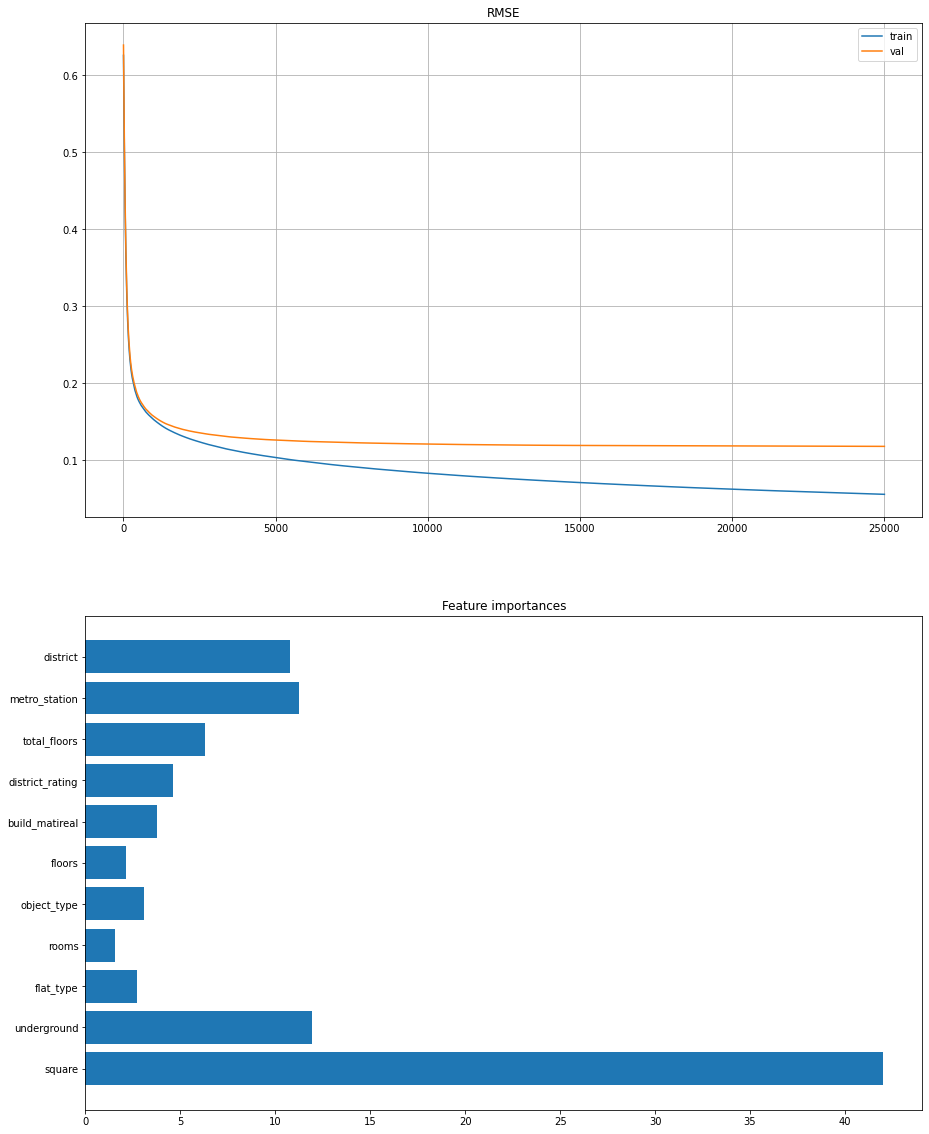

In [120]:
ctr = CatBoostRegressor( loss_function = 'RMSE',
                         eval_metric = 'RMSE',
                         learning_rate=0.01,
                         iterations=25000, # обучаем до overfitting'a
                         l2_leaf_reg=1,
                         depth=8,
                         one_hot_max_size = 77,
                         leaf_estimation_method = 'Gradient',
                         random_seed=RANDOM_SEED,
                         od_type='Iter',
                         od_wait=1000,
                         task_type='CPU')

flats_model, prediction = fp.fit_model(df, ctr)

Очень хорошо. Удалось улучшить результат с **13.92%** до **7.05%** (почти в два раза).

In [121]:
prediction

,target,predict
22067,11000000.0,1.045492e+07
16510,11300000.0,1.117490e+07
12423,7030560.0,7.112185e+06
39858,5320000.0,5.302036e+06
26087,3070000.0,3.129605e+06
...,...,...
29020,6960600.0,6.671357e+06
17844,6710000.0,6.241534e+06
25697,3800000.0,3.741479e+06
4212,8960319.0,8.933591e+06
